### Retrieval-Augmented Generation (RAG) - Query Translation -  Decomposition
**Problem:** User queries are challenging. If user provides an ambiguous query, they will get ambiguous matches. 
             LLMs just follow what was in the context and produce the results as it is.

**Solution:** There are multiple ways to tackle the above problem.

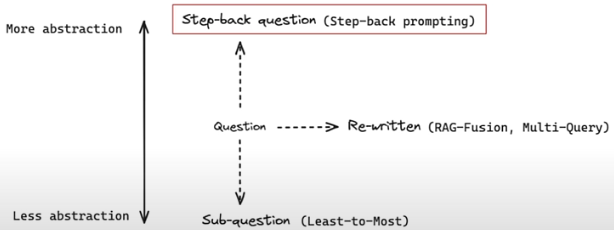
             
- More Abstraction: Refers to generalizing or **stepping back** to view the question from a higher-level perspective.
  - Example: Instead of directly asking for a specific answer, you might frame a question like, "What broader concepts should I consider for this problem?"
- Less Abstraction: Refers to breaking the question into specific, granular sub-questions that are easier to answer..
  - Example: For the question, "How does climate change affect agriculture?" sub-questions might be:
    - "What is climate change?"
    - "What are the main impacts of climate change on crop growth?"
- Rewriting the query using RAG-Fusion or Multi-Query
  - **RAG-Fusion**: Combining retrieved documents or information from multiple sources to provide a more comprehensive context.
  - **Multi-Query**: Generating multiple variations of the question to improve the chances of retrieving relevant information.
  - **Decomposition**: Breaking down a complex query into smaller sub-queries to improve the retrieval process. 

This section discusses on **Step-back using Few-Shot Examples**, a Query Translation in RAG.

##### Key Highlights:
- **Implement Step-back Query Translation**
  - **Step-back using Few-Shot** in the context of RAG involves leveraging examples (few-shot learning) during the iterative process of query reformulation and retrieval improvement.
  - How Step-back using Few-Shot works?
    - Initial Query and Retrieval. 
    - Evaluate the initial results: The system evaluates the relevance of the retrieved results. If the results are too general, incomplete, or off-topic, the system identifies the need for refinement (step-back).
    - Incorporate few shot examples:
      - The system uses the few-shot learning framework, where examples of similar query transformations are used to guide query reformulation.
      - Few examples of Original --> Reformulated Query:
        - "Challenges in renewable energy?" → "What are the challenges in renewable energy storage?"
        - "How does AI work?" → "Explain how neural networks function in AI."
    - Query Reformulation:
      - Using the examples of defined Original --> Reformulated queries
      - Example:
        - Based on the few-shot example "Challenges in X domain" → "Challenges in X technology", the query becomes:
        - Reformulated Query: "What are the ethical and technical challenges of AI in healthcare?"
    - Improved Retrieval: The reformulated query is sent to the retriever, fetching more relevant and focused documents.
    - The generator synthesizes the improved results to create a more accurate and comprehensive response to the original query.
  

  

##### What's Next: 


#### Install required libraries

In [1]:
# Install required libraries
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### Import required libraries

In [2]:
import os # Operating system relevant tasks
from dotenv import load_dotenv
import bs4 # Import Beautiful Soap, a Python Web Scrapping package
from langchain_community.document_loaders import WebBaseLoader # Load documents from website
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma # Import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain import hub # Python library containing pre-defined Prompts, Chains for LLM applications
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain.prompts import ChatPromptTemplate
from langchain_core.prompts import FewShotChatMessagePromptTemplate
import numpy as np
from langchain.load import dumps, loads
from operator import itemgetter

USER_AGENT environment variable not set, consider setting it to identify your requests.


#### Environment Setup

In [3]:
# Load environment variables from .env file
load_dotenv()

# API key provides authentication to access LangChain service 
os.environ['LANGCHAIN_TRACING_V2'] = 'true' # Enables LangChain Tracing V2, a mechanism to enable and monitor the execution of LangChain applications for debugging and optimization
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com' # Configures the LangChain API End Point to use LangChain for tracing
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
# API key to access OpenAI services
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

#### RAG Process

##### Load, Split, Index

In [4]:
## Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load() 

## Split the documents based on tokens
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)
splits = text_splitter.split_documents(blog_docs)

## Calculate the vector embeddings of the splits, store in the vector store and convert the vector store into a retriever object
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings()) # Store the vector embeddings of splits in Chroma DB

## Retrieve the documents that are closing matching with prompt using KNN
retriever = vectorstore.as_retriever(search_kwargs={"k": 5}) 

#### **Prompt - Step-back using Few-Shot Examples**
Write a Prompt in such a way that the reformulated query is generated using Few-Shot examples

In [5]:
# Few-Shot Examples
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]

# Transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [6]:
# Generate reformulated query using Few-Shot examples
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question": question})

'What is the process of breaking down tasks for LLM agents?'

##### Invoke LLM

In [7]:
# Generate Response using Few-Shot Step-back
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

chain.invoke({"question": question})

'Task decomposition for LLM agents refers to the process of breaking down complex tasks into smaller, more manageable subgoals. This allows the agent to efficiently handle intricate tasks by dividing them into simpler steps. Task decomposition is crucial for LLM-powered autonomous agents as it enables them to plan ahead and navigate through a series of actions to achieve a desired outcome.\n\nOne approach to task decomposition is through techniques like Chain of Thought (CoT) and Tree of Thoughts. CoT prompts the model to "think step by step," utilizing more computation to break down hard tasks into smaller steps. This method transforms large tasks into multiple manageable tasks, providing insights into the model\'s thinking process. On the other hand, Tree of Thoughts extends CoT by exploring multiple reasoning possibilities at each step, creating a tree structure of thought steps and generating multiple thoughts per step. The search process can be conducted through breadth-first sear

**Few Takeaways:**

Benefits of Step-back Query Translation:
- Improved Retrieval Accuracy:
    - Step-back query translation generates alternative queries that are more precise or better scoped, leading to the retrieval of documents that are more relevant to the user's intent.
- Enables Multi-Faceted Responses:
    - By retrieving results from both the original and step-back queries, the system can provide responses that address multiple dimensions of a question.
        - Example: For "Challenges of AI in healthcare", step-back might break it into technical challenges and ethical challenges.
